# Using CNNs on TFRs

General Pipeline:

Classify 4s subsegments --> threshold --> classify full recording

- Preprocessing = BPF (0.5-50Hz), Keep all electrodes separate, TFR using Morlet wavelets at canonical freq bands
- Feature Extraction & Classification of 4s subsegments = CNN
- %subsegments=preictal --> Threshold hyperparameter --> classify preictal vs interictal

In [1]:
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import (periodogram as periodogram,
                         butter as butter,
                         lfilter as lfilter)
from timeit import default_timer as timer
from sklearn.decomposition import PCA as PCA
from sklearn.svm import SVC as SVC
from sklearn.model_selection import train_test_split as train_test_split
from sklearn.metrics import precision_recall_fscore_support as prf
from copy import copy as copy
from tqdm.notebook import tqdm
import mne
from scipy.signal import decimate

In [5]:
class SubSegment:
    def __init__(self, data, data_length_sec, fs, channels, sequence):
        self.data = data
        self.data_length_sec = data_length_sec
        self.fs = fs
        self.channels = channels
        self.sequence = sequence
        self.t = np.linspace(0, self.data_length_sec, self.data.shape[0])
    
    def get_psd(self, data, f_low=0.5, f_high=50):
        data = np.mean(data, axis=1)
        self.freq, self.psd, self.band_psd = [], [], []
        band_lims = (0, 4, 8, 12, 30, 100)
        freq, psd = periodogram(data, self.fs)
        psd = 10*np.log10(psd)
        self.psd = psd[np.logical_and(freq>=0.5, freq<=50)]
        self.freq = freq[np.logical_and(freq>=0.5, freq<=50)]
        for l_lim, u_lim in zip(band_lims[:-1], band_lims[1:]):
            band_mask = np.logical_and(freq>l_lim, freq<=u_lim)
            band_power = np.sum(psd[band_mask]) / np.sum(band_mask)
            self.band_psd.append(band_power)
        self.band_psd = np.array(self.band_psd)
    
    def get_tfr(self, data):
        self.band_centers = [2, 6, 10, 20, 40]
        data = np.swapaxes(np.expand_dims(data, axis=0), 1, 2)
        tfr = mne.time_frequency.tfr_array_morlet(data, freqs=self.band_centers, sfreq=int(self.fs), n_cycles=2,
                                                  output='complex')
        self.tfr = tfr[0]
        
    def get_ispc(self):
        num_ch = len(self.channels)
        num_bands = len(self.band_centers)
        phase = np.angle(self.tfr)
        ispc = np.zeros(num_bands)
        num_pairs = 0
        for i in range(num_ch):
            for j in range(i+1, num_ch):
                phase_diff = phase[i, :, :] - phase[j, :, :]
                ispc += np.abs(np.mean(np.exp(1j*phase_diff), axis=1))
                num_pairs += 1
        self.ispc = ispc / num_pairs
    def minmax_norm(self, x):
        max_x = np.max(np.abs(x))
        minmax = np.array([max_x])
        norm_x = x / max_x
        return norm_x, minmax
        
    def get_feats(self, data, f_low=0.5, f_high=50):
        #skip normalization entirely to improve performance
        self.get_psd(data, f_low, f_high)
        self.get_tfr(data)
        self.get_ispc()
        self.feats = np.concatenate((self.band_psd, self.ispc), axis=0)
            
    def plot_raw_data(self):
        fig, ax = plt.subplots()
        ax.plot(self.t, self.data)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_raw_zoomed(self, start_idx, end_idx):
        fig, ax = plt.subplots()
        ax.plot(self.t[start_idx:end_idx], self.data[start_idx:end_idx])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_psd(self):
        fig, ax = plt.subplots()
        ax.plot(self.freq, self.psd)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Spectral Power (dB)")
        return fig, ax
    
    def plot_band_psd(self):
        x = np.arange(5)
        bands = ["delta (0-4Hz)", "theta (4-8Hz)", "alpha (8-12Hz)", "beta (12-30Hz)", "gamma (30-50Hz)"]
        fig, ax = plt.subplots()
        ax.scatter(x, self.band_psd)
        ax.set_xticks(x)
        ax.set_xticklabels(bands)
        ax.set_ylabel("Spectral Power Density (dB/Hz)")
        return fig, ax
    
    def plot_tfr(self, channels):
        n_down = 20 #downsampling factor for plotting
        down_t = self.t[:len(self.t):n_down]
        for channel in channels:
            i = self.channels.index(channel)
            down_tfr = decimate(self.tfr[i], n_down)
            down_amp = np.abs(down_tfr)
            down_phase = np.angle(down_tfr)
            fig, axs = plt.subplots(2, 1)
            pcm_amp = axs[0].pcolormesh(down_t, self.band_centers, down_amp, shading='auto', cmap='gray')
            cbar_amp = fig.colorbar(pcm_amp, ax=axs[0])
            cbar_amp.set_label("Amplitude (uV)")
            pcm_phase = axs[1].pcolormesh(down_t, self.band_centers, down_phase, shading='auto', cmap='gray')
            cbar_phase = fig.colorbar(pcm_phase, ax=axs[1])
            cbar_phase.set_label("Phase (radians)")
            fig.supxlabel("Time (s)")
            fig.supylabel("Frequency (Hz)")
            fig.suptitle("Channel {}".format(channel))
    
    def plot_all(self, start_idx, end_idx):
        self.plot_raw_data()
        self.plot_raw_zoomed(start_idx, end_idx)
        self.plot_psd()
        self.plot_band_psd()
        self.plot_tfr(self.channels)

In [6]:
class Segment(SubSegment):
    def __init__(self, path, var):
        self.load_struct(path, var)
        self.filter_seg(fs=self.fs)
        self.split_seg(4)
        
    def load_struct(self, path, var):
        basepath = os.path.dirname(os.path.realpath("__file__"))
        seg_path = os.path.join(basepath, path)
        seg_struct = loadmat(seg_path)[var][0][0]
        self.raw_data = np.transpose(seg_struct[0])
        self.data_length_sec = seg_struct[1][0][0]
        self.fs = seg_struct[2][0][0]
        self.channels = []
        for channel in seg_struct[3][0]:
            self.channels.append(channel[0])
        self.sequence = seg_struct[4][0][0]
        self.t = np.linspace(0, self.data_length_sec, self.raw_data.shape[0])
    
    def filter_seg(self, filt_ord=1, cutoff_low=0.5, cutoff_high=50, fs=1):
        b, a = butter(filt_ord, [cutoff_low, cutoff_high], btype="bandpass", fs=fs)
        self.data = lfilter(b, a, self.raw_data)
    
    def split_seg(self, t_split):
        num_seg = self.data_length_sec // t_split
        seg_len = t_split*self.fs
        self.subsegments = []
        prog_bar = tqdm(range(num_seg), leave=False)
        for i in prog_bar:
            seg_data = self.data[i*seg_len:(i+1)*seg_len]
            seg = SubSegment(seg_data, t_split, self.fs, self.channels, self.sequence)
            seg.get_feats(seg_data)
            self.subsegments.append(seg)
        prog_bar.close()

In [7]:
interictal_1 = Segment("Patient_1_interictal_segment_0001.mat", 'interictal_segment_1')

  0%|          | 0/150 [00:00<?, ?it/s]

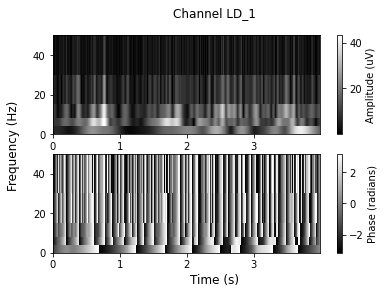

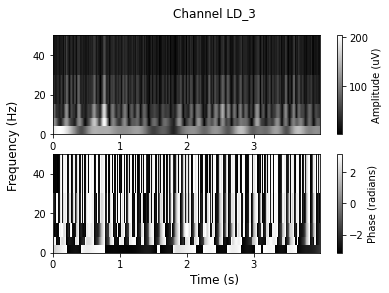

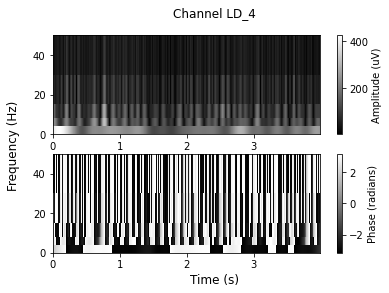

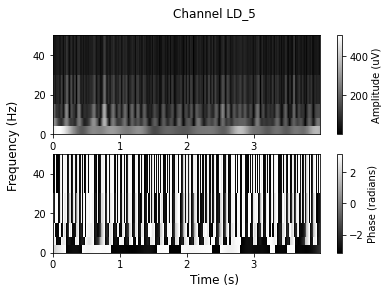

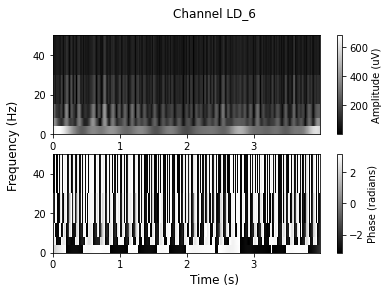

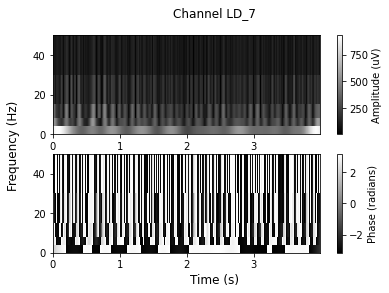

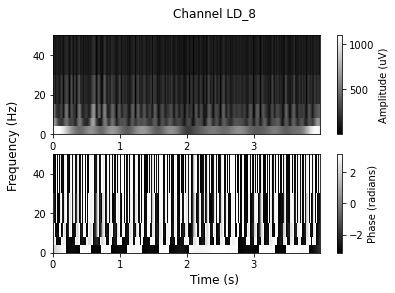

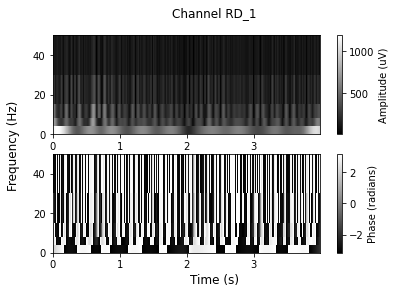

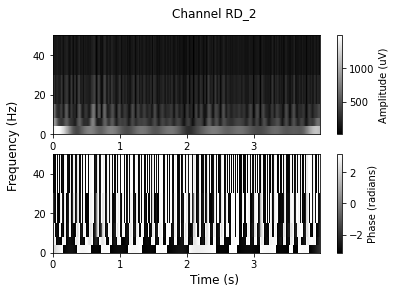

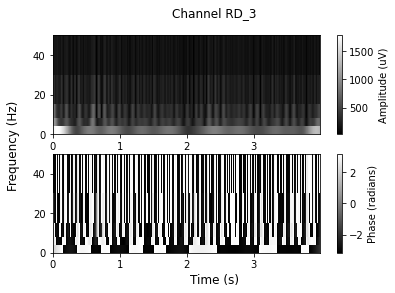

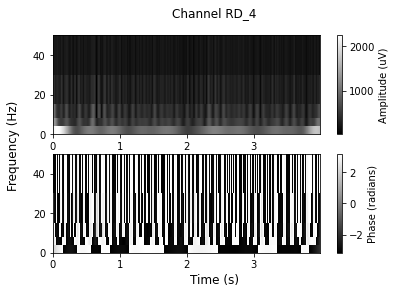

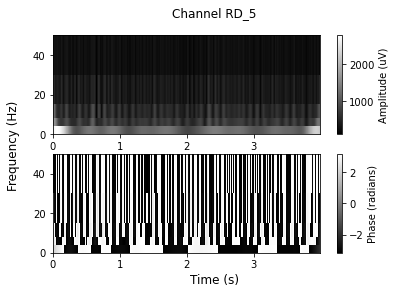

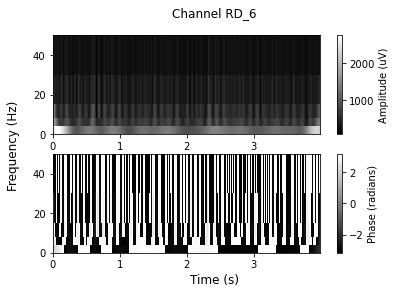

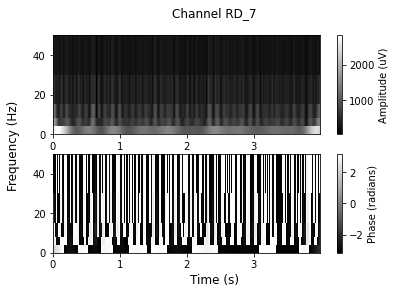

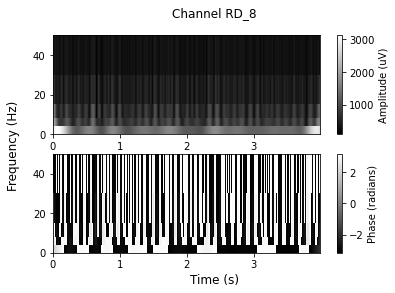

In [5]:
interictal_1.subsegments[123].plot_tfr(interictal_1.channels)

## LOO Cross-Validation on patient 1

In [8]:
def listsubfolders(root):
    contents = os.listdir(root)
    subfolders = []
    for item in os.listdir(root):
        item_path = os.path.join(root, item)
        if not(os.path.isfile(item_path)):
            subfolders.append(item)
    return subfolders

def load_patients(pat_names):
    root = "seizure-prediction"
    i_feats, p_feats = [], []
    for folder in listsubfolders(root):
        if not(folder in pat_names):
            continue
        print(folder)
        datapath = os.path.join(os.path.join(root, folder), folder)
        matfiles = [file for file in os.listdir(datapath) if not("test" in file or ".DS_Store" in file)]
        interictal_seg, preictal_seg = None, None
        for matfile in tqdm(matfiles):
            print(matfile)
            seg_path = os.path.join(datapath, matfile)
            if "interictal" in matfile:
                seg_name = "interictal_segment_"+str(int(matfile[-8:-4]))
                interictal_seg = Segment(seg_path, seg_name)
                seg_feats = []
                for subseg in interictal_seg.subsegments:
                    seg_feats.append(subseg.feats)
                i_feats.append(seg_feats)
            else: #preictal
                seg_name = "preictal_segment_"+str(int(matfile[-8:-4]))
                preictal_seg = Segment(seg_path, seg_name)
                seg_feats = []
                for subseg in preictal_seg.subsegments:
                    seg_feats.append(subseg.feats)
                p_feats.append(seg_feats)
    return i_feats, p_feats

In [15]:
i_feats, p_feats = load_patients(["Patient_1"])

Patient_1


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [39]:
#save features for later
i_feats = np.array(i_feats)
p_feats = np.array(p_feats)
np.save("i_feats.npy", i_feats)
np.save("p_feats.npy", p_feats)

In [43]:
#load features
i_feats = np.load("i_feats.npy")
p_feats = np.load("p_feats.npy")

In [9]:
def loo_xval(i_feats, p_feats):
    loo_accs, i_seg_pred, p_seg_pred = [], [], []
    preictal_thresh = 0.25
    for i in tqdm(range(len(i_feats))):
        p_loo_seg_list = p_feats[i%len(p_feats)]
        p_feat = p_feats.copy()
        p_feat = np.delete(p_feat, i%len(p_feats), axis=0)
        p_feat = np.reshape(p_feat, (p_feat.shape[0]*p_feat.shape[1], p_feat.shape[2]))

        i_loo_seg_list = i_feats[i]
        i_feat = i_feats.copy()
        i_feat = np.delete(i_feat, i, axis=0)
        i_feat = np.reshape(i_feat, (i_feat.shape[0]*i_feat.shape[1], i_feat.shape[2]))

        #PCA
        pca = PCA()
        ip_feat = np.concatenate((i_feat, p_feat), axis=0)
        pca_feat = pca.fit_transform(ip_feat)
        num_i = len(i_feat)
        labels = [0]*num_i + [1]*(len(ip_feat)-num_i)

        #SVM
        svc = SVC()
        svc.fit(pca_feat, labels)
        pred_train = svc.predict(pca_feat)
        zero = np.array(0)
        one = np.array(1)

        #LOO Eval
        loo_ip_feat = np.concatenate((i_loo_seg_list, p_loo_seg_list), axis=0)
        loo_labels = [0]*len(i_loo_seg_list) + [1]*len(p_loo_seg_list)
        loo_pca_feats = pca.transform(loo_ip_feat)
        loo_pred = svc.predict(loo_pca_feats)
        loo_accs.append(svc.score(loo_pca_feats, loo_labels))
        if np.sum(loo_pred[:len(i_loo_seg_list)]) / len(i_loo_seg_list) > preictal_thresh:
            i_seg_pred.append(1)
        else:
            i_seg_pred.append(0)
        if i < len(p_feats):
            if np.sum(loo_pred[len(i_loo_seg_list):]) / len(p_loo_seg_list) > preictal_thresh:
                p_seg_pred.append(1)
            else:
                p_seg_pred.append(0)
    return loo_accs, i_seg_pred, p_seg_pred 

In [55]:
loo_accs, i_seg_pred, p_seg_pred = loo_xval(i_feats, p_feats)

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
def print_performance(loo_accs, i_seg_pred, p_seg_pred):
    loo_accs = np.array(loo_accs)
    cross_val_acc = np.mean(loo_accs)
    cross_val_std = np.std(loo_accs)
    print("LOO Cross-Validated Subsegment Accuracy: {} +/- {}".format(cross_val_acc, cross_val_std))
    pred_test = i_seg_pred + p_seg_pred
    y_test = [0]*len(i_seg_pred) + [1]*len(p_seg_pred)
    precision, recall, f_score, _ = prf(y_test, pred_test)
    acc = sum(np.array(pred_test) == np.array(y_test)) / len(y_test)
    print("LOO Cross-Validated Segment accuracy: {}, precision: {}, recall: {}, f_score: {}".format(
        acc, precision, recall, f_score))

In [57]:
print_performance(loo_accs, i_seg_pred, p_seg_pred)

LOO Cross-Validated Subsegment Accuracy: 0.8114 +/- 0.13549266482810876
LOO Cross-Validated Segment accuracy: 0.9705882352941176, precision: [0.98       0.94444444], recall: [0.98       0.94444444], f_score: [0.98       0.94444444]


## Focus on TFR greyscaled for CNN

In [2]:
class SubSegment:
    def __init__(self, data, data_length_sec, fs, channels, sequence):
        self.data = data
        self.data_length_sec = data_length_sec
        self.fs = fs
        self.channels = channels
        self.sequence = sequence
        self.t = np.linspace(0, self.data_length_sec, self.data.shape[0])
    
    def get_tfr(self, data):
        self.band_centers = [2, 6, 10, 20, 40]
        data = np.swapaxes(np.expand_dims(data, axis=0), 1, 2)
        tfr = mne.time_frequency.tfr_array_morlet(data, freqs=self.band_centers, sfreq=int(self.fs), n_cycles=2,
                                                  output='complex')
        self.tfr = tfr[0]
        self.phase = np.angle(self.tfr)
        self.amp = np.abs(self.tfr)
        
    def minmax_norm(self, x):
        max_x = np.max(np.abs(x))
        minmax = np.array([max_x])
        norm_x = x / max_x
        return norm_x, minmax
        
    def get_feats(self, data, f_low=0.5, f_high=50):
        #skip normalization entirely to improve performance
        self.get_tfr(data)
        norm_phase, max_phase = self.minmax_norm(self.phase)
        norm_amp, max_amp = self.minmax_norm(self.amp)
        norm_phase = decimate(decimate(norm_phase, 10), 2)
        norm_amp = decimate(decimate(norm_amp, 10), 2)
        self.feats = np.concatenate((norm_phase, norm_amp), axis=0)
            
    def plot_raw_data(self):
        fig, ax = plt.subplots()
        ax.plot(self.t, self.data)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_raw_zoomed(self, start_idx, end_idx):
        fig, ax = plt.subplots()
        ax.plot(self.t[start_idx:end_idx], self.data[start_idx:end_idx])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_tfr(self, channels):
        n_down = 20 #downsampling factor for plotting
        down_t = self.t[:len(self.t):n_down]
        for channel in channels:
            i = self.channels.index(channel)
            down_tfr = decimate(self.tfr[i], n_down)
            down_amp = np.abs(down_tfr)
            down_phase = np.angle(down_tfr)
            fig, axs = plt.subplots(2, 1)
            pcm_amp = axs[0].pcolormesh(down_t, self.band_centers, down_amp, shading='auto', cmap='gray')
            cbar_amp = fig.colorbar(pcm_amp, ax=axs[0])
            cbar_amp.set_label("Amplitude (uV)")
            pcm_phase = axs[1].pcolormesh(down_t, self.band_centers, down_phase, shading='auto', cmap='gray')
            cbar_phase = fig.colorbar(pcm_phase, ax=axs[1])
            cbar_phase.set_label("Phase (radians)")
            fig.supxlabel("Time (s)")
            fig.supylabel("Frequency (Hz)")
            fig.suptitle("Channel {}".format(channel))
    
    def plot_tfr_feat(self, channels):
        n_down = 20 #downsampling factor for plotting
        down_t = self.t[:len(self.t):n_down]
        for channel in channels:
            i = self.channels.index(channel)
            down_tfr = self.feats
            down_amps = down_tfr[15:]
            down_phases = down_tfr[:15]
            down_amp = down_amps[i]
            down_phase = down_phases[i]
            fig, axs = plt.subplots(2, 1)
            pcm_amp = axs[0].pcolormesh(down_t, self.band_centers, down_amp, shading='auto', cmap='gray')
            cbar_amp = fig.colorbar(pcm_amp, ax=axs[0])
            cbar_amp.set_label("Amplitude (uV)")
            pcm_phase = axs[1].pcolormesh(down_t, self.band_centers, down_phase, shading='auto', cmap='gray')
            cbar_phase = fig.colorbar(pcm_phase, ax=axs[1])
            cbar_phase.set_label("Phase (radians)")
            fig.supxlabel("Time (s)")
            fig.supylabel("Frequency (Hz)")
            fig.suptitle("Channel {}".format(channel))

In [3]:
class Segment(SubSegment):
    def __init__(self, path, var):
        self.load_struct(path, var)
        self.filter_seg(fs=self.fs)
        self.split_seg(4)
        
    def load_struct(self, path, var):
        basepath = os.path.dirname(os.path.realpath("__file__"))
        seg_path = os.path.join(basepath, path)
        seg_struct = loadmat(seg_path)[var][0][0]
        self.raw_data = np.transpose(seg_struct[0])
        self.data_length_sec = seg_struct[1][0][0]
        self.fs = seg_struct[2][0][0]
        self.channels = []
        for channel in seg_struct[3][0]:
            self.channels.append(channel[0])
        self.sequence = seg_struct[4][0][0]
        self.t = np.linspace(0, self.data_length_sec, self.raw_data.shape[0])
    
    def filter_seg(self, filt_ord=1, cutoff_low=0.5, cutoff_high=50, fs=1):
        b, a = butter(filt_ord, [cutoff_low, cutoff_high], btype="bandpass", fs=fs)
        self.data = lfilter(b, a, self.raw_data)
    
    def split_seg(self, t_split):
        num_seg = self.data_length_sec // t_split
        seg_len = t_split*self.fs
        self.subsegments = []
        prog_bar = tqdm(range(num_seg), leave=False)
        for i in prog_bar:
            seg_data = self.data[i*seg_len:(i+1)*seg_len]
            seg = SubSegment(seg_data, t_split, self.fs, self.channels, self.sequence)
            seg.get_feats(seg_data)
            self.subsegments.append(seg)
        prog_bar.close()

In [42]:
interictal_1 = Segment("Patient_1_interictal_segment_0001.mat", 'interictal_segment_1')

  0%|          | 0/150 [00:00<?, ?it/s]

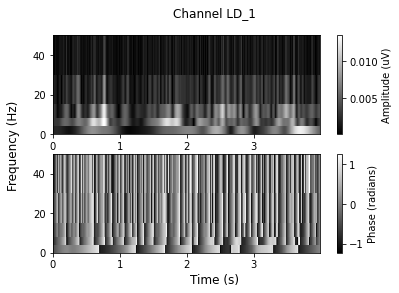

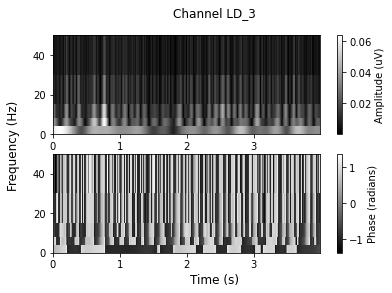

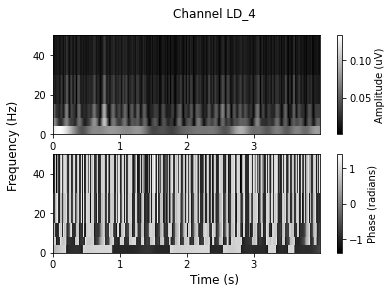

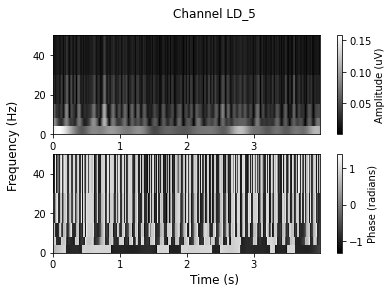

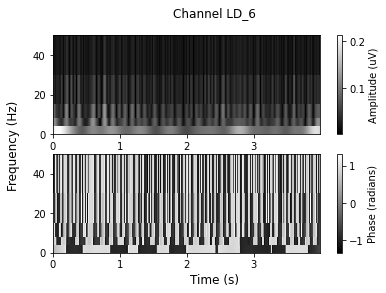

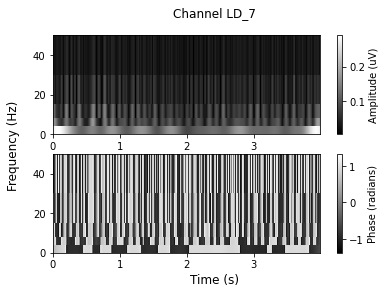

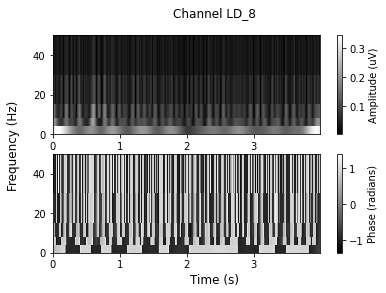

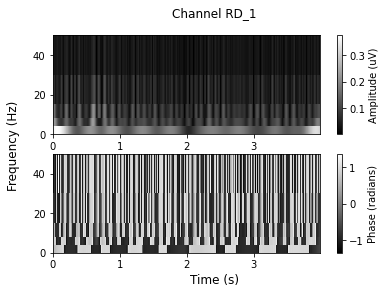

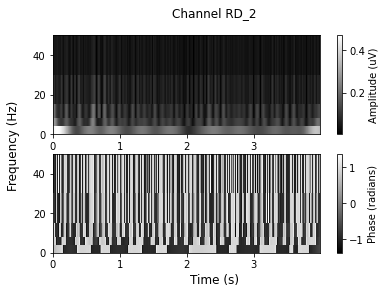

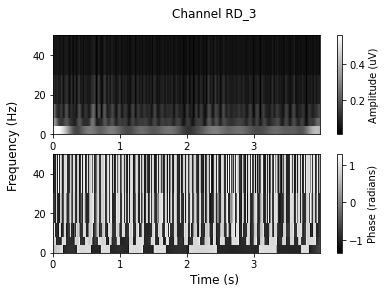

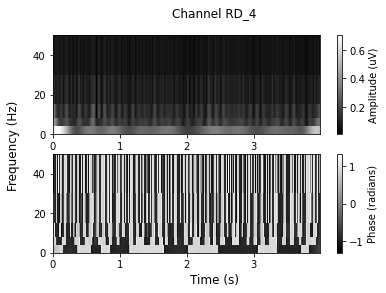

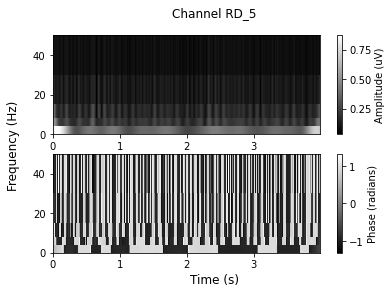

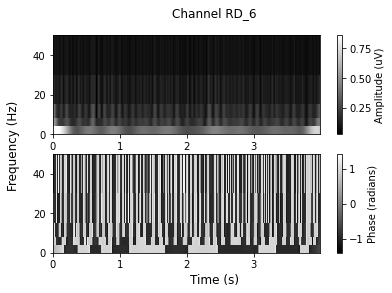

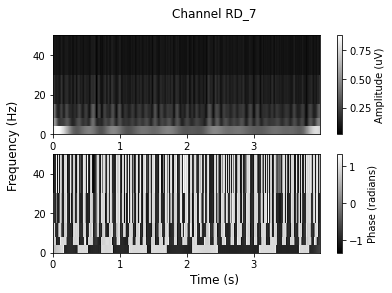

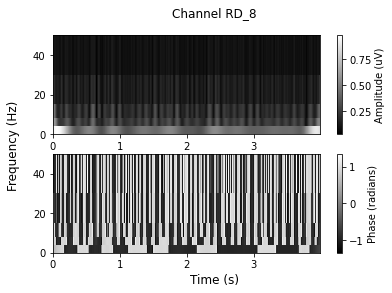

In [43]:
interictal_1.subsegments[123].plot_tfr_feat(interictal_1.channels)

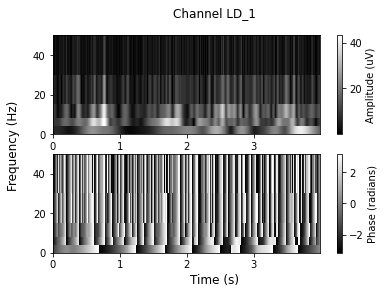

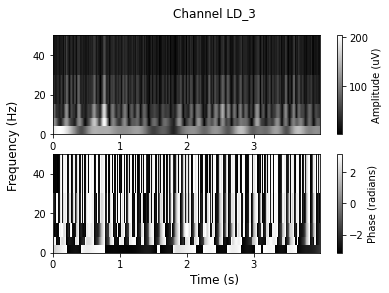

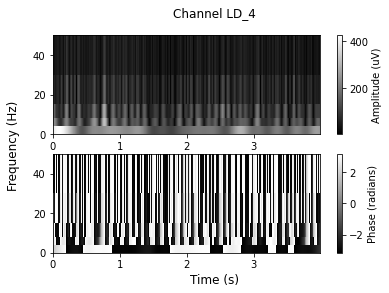

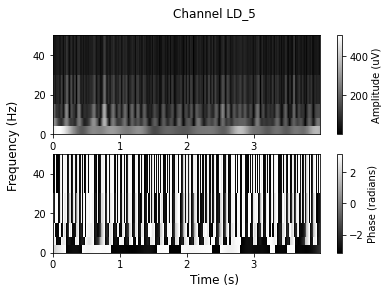

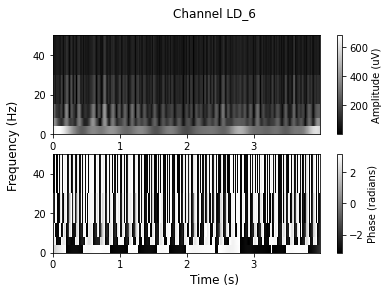

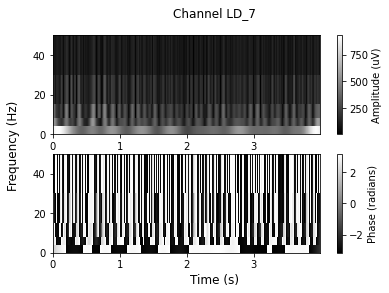

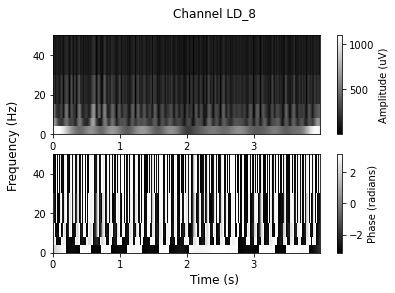

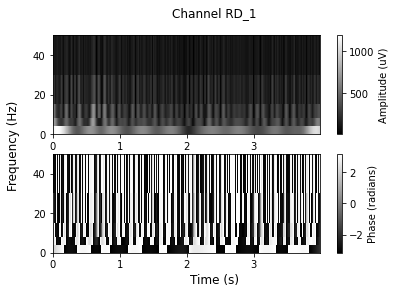

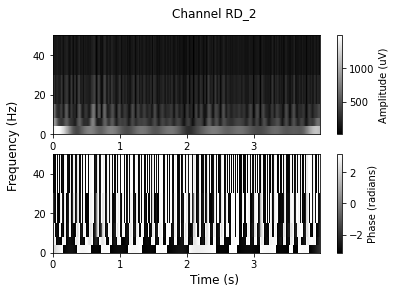

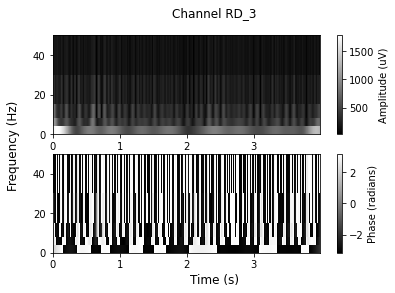

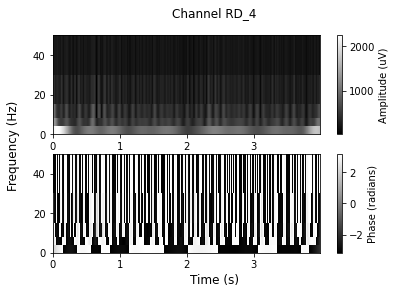

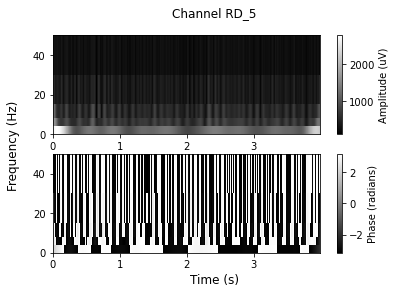

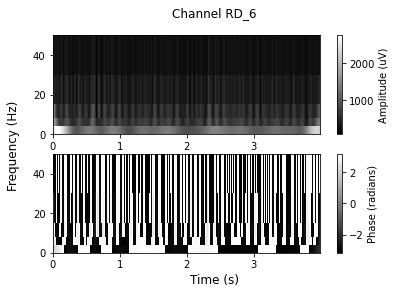

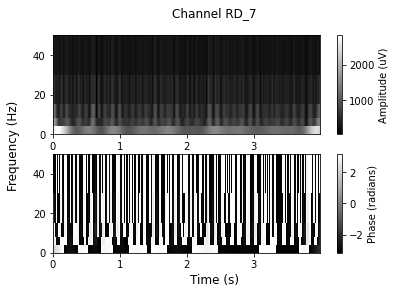

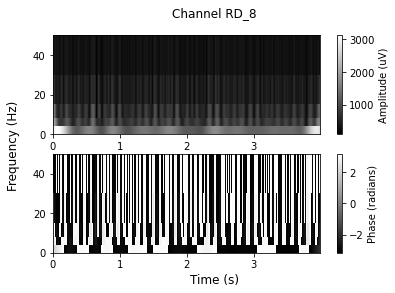

In [12]:
interictal_1.subsegments[123].plot_tfr(interictal_1.channels)

In [13]:
interictal_1.subsegments[123].feats.shape

(30, 5, 20000)

In [4]:
def preproc_patients(pat_names):
    root = "seizure-prediction"
    saveroot = "DeepPreProcData"
    if not(os.path.exists(saveroot)):
        os.mkdir(savedir)
    for folder in listsubfolders(root):
        if not(folder in pat_names):
            continue
        print(folder)
        datapath = os.path.join(os.path.join(root, folder), folder)
        save_pat_path = os.path.join(saveroot, folder)
        if not(os.path.exists(save_pat_path)):
            os.mkdir(save_pat_path)
        matfiles = [file for file in os.listdir(datapath) if not("test" in file or ".DS_Store" in file)]
        interictal_seg, preictal_seg = None, None
        for matfile in tqdm(matfiles):
            seg_path = os.path.join(datapath, matfile)
            if "interictal" in matfile:
                seg_name = "interictal_segment_"+str(int(matfile[-8:-4]))
                interictal_seg = Segment(seg_path, seg_name)
                seg_feats = []
                for subseg in interictal_seg.subsegments:
                    seg_feats.append(subseg.feats)
                X = np.array(seg_feats)
                y = np.array(0)
            else: #preictal
                seg_name = "preictal_segment_"+str(int(matfile[-8:-4]))
                preictal_seg = Segment(seg_path, seg_name)
                seg_feats = []
                for subseg in preictal_seg.subsegments:
                    seg_feats.append(subseg.feats)
                X = np.array(seg_feats)
                y = np.array(1)
            save_seg_path = os.path.join(save_pat_path, seg_name)
            if not(os.path.exists(save_seg_path)):
                os.mkdir(save_seg_path)
            for i, subseg in enumerate(X):
                filepath = os.path.join(save_seg_path, str(i))
                np.savez(filepath, X=subseg, y=y)

In [246]:
preproc_patients(["Patient_1"])

Patient_1


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

## CNN

In [114]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.integrate import trapz as trapz

In [115]:
batch_size = 50 // 2

Set up Dataset and Dataloader

In [116]:
class SeizureData(Dataset):
    """Seizure Prediction Dataset"""
    
    def __init__(self, root, pat_name, seg_names, n_subseg):
        self.root = root
        self.pat_name = pat_name
        self.dir_path = os.path.join(root, pat_name)
        self.seg_names = seg_names
        self.n_seg = len(seg_names)
        self.n_subseg = n_subseg
    
    def __len__(self):
        return self.n_seg*self.n_subseg
    
    def __getitem__(self, idx):
        seg_idx = idx // self.n_subseg
        subseg_idx = idx % self.n_subseg
        seg_path = os.path.join(self.dir_path, self.seg_names[seg_idx])
        subseg_path = os.path.join(seg_path, str(subseg_idx)+".npz")
        subseg = np.load(subseg_path)
        X = torch.tensor(subseg['X']).float()
        y = torch.tensor(subseg['y']).float()
        return X, y

inter_segs = [seg_name for seg_name in os.listdir("DeepPreProcData/Patient_1") if "interictal" in seg_name]
pre_segs = [seg_name for seg_name in os.listdir("DeepPreProcData/Patient_1") if "preictal" in seg_name]
train_segs = inter_segs[:9]+pre_segs[:9]
test_segs = inter_segs[9:18]+pre_segs[9:]
n_subseg = 150
train_dataset = SeizureData("DeepPreProcData", "Patient_1", train_segs, n_subseg)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SeizureData("DeepPreProcData", "Patient_1", test_segs, n_subseg)
test_dataloader = DataLoader(test_dataset, batch_size=n_subseg, shuffle=False)

Define Model Class

In [117]:
class PredIctal(nn.Module):
    """CNN for Predicting seizure from 4s subsegments"""
    
    def __init__(
                self,
                init_w=1000,
                init_h=5,
                num_channels=30,
                width=10,
                latent_size=20,
                filter_size=5,
                pool_filter_size=(1, 10),
                pad=0,
                stride=1,
                pool_stride=2):
        #inheriting nn.Module initialization
        super(PredIctal, self).__init__()
        
        #architecture variables
        self.init_w = init_w
        self.init_h = init_h
        self.num_channels = num_channels
        self.width = width
        self.latent_size = latent_size
        self.filter_size = filter_size
        self.pool_filter_size = pool_filter_size
        self.pad = pad
        self.stride = stride
        self.pool_stride = pool_stride
        
        #output sizes
        output1_w = (init_w - filter_size + 2*pad) // stride + 1
        output1_h = (init_h - filter_size + 2*pad) // stride + 1
        output2_w = (output1_w - pool_filter_size[1]) // pool_stride + 1
        output2_h = (output1_h - pool_filter_size[0]) // pool_stride + 1
        self.linear_size = output2_w * output2_h * self.width
        
        #architecture
        self.architecture = nn.Sequential(
            nn.Conv2d(self.num_channels, self.width, self.filter_size, self.stride, self.pad),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_filter_size, self.pool_stride),
            nn.Flatten(),
            nn.Linear(self.linear_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.architecture(x).squeeze(1)

PredIctal()

PredIctal(
  (architecture): Sequential(
    (0): Conv2d(30, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 10), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=4940, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Training Hyperparameters

Note: $\lambda_{norm}$ is a L2 Norm Regularization parameter from [here](https://towardsdatascience.com/weight-decay-and-its-peculiar-effects-66e0aee3e7b8) 

In [118]:
learning_rate = 0.01 / 2
num_epochs = 10
epoch_nums = [epoch for epoch in range(num_epochs)]
lambda_norm = 0.05
weight_decay = lambda_norm*np.sqrt(batch_size/(num_epochs*len(train_dataset)))

Define weight initializer, training and eval loops

In [140]:
def weights_init(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
    return
def train_loop(dataloader, model, loss_fn, optimizer, print_batch=False):
    prog_bar =  tqdm(dataloader, leave=False)
    for (x, y) in prog_bar:
        #Forward Pass
        pred = model(x)
        loss = loss_fn(pred, y)
        
        #Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    prog_bar.close()
    return

def eval_loop(dataloader, model, loss_fn, thresh=0.5, seg=False):
    eval_loss, ys, preds, true_preds = 0, [], [], []
    with torch.no_grad():
        prog_bar = tqdm(dataloader, leave=False)
        for x, y in prog_bar:
            pred = model(x)
            if seg:
                seg_pred = torch.mean(pred)
                true_preds.append(seg_pred)
                seg_y = y[0]
                eval_loss += loss_fn(seg_pred, seg_y).item()
                ys.append(seg_y.item())
                if seg_pred.item() >= thresh:
                    preds.append(1)
                else:
                    preds.append(0)
            else:
                eval_loss += loss_fn(pred, y).item()
                for yi, predi in zip(y, pred):
                    ys.append(yi.item())
                    true_preds.append(predi.item())
                    if predi.item() >= thresh:
                        preds.append(1)
                    else:
                        preds.append(0)
        prog_bar.close()
    avg_loss = eval_loss / len(dataloader)
    
    ys = np.array(ys)
    preds = np.array(preds)
    acc = np.sum(ys==preds) / len(ys)
    prec, recall, f1, _ = prf(ys, preds)
    stats = avg_loss, acc, prec, recall, f1
    predsNlabels = ys, preds, true_preds
    return stats, predsNlabels

def roc_eval_loop(y, true_preds, thresholds):
    fprs, tprs = [], []
    for thresh in thresholds:
        preds = true_preds >= thresh
        true_pos = np.sum(np.logical_and(y==preds, preds==1))
        false_pos = np.sum(np.logical_and(y!=preds, preds==1))
        true_neg = np.sum(np.logical_and(y==preds, preds==0))
        false_neg = np.sum(np.logical_and(y!=preds, preds==0))
        tpr = true_pos / (false_neg + true_pos) #true positive rate
        fpr = false_pos / (false_pos + true_neg) #false positive rate
        tprs.append(tpr)
        fprs.append(fpr)
    fprs, tprs = np.flip(fprs), np.flip(tprs)
    auc = trapz(tprs, fprs)

    return tprs, fprs, auc

def plot_init(dataloader, model, idx, ch_idx, freq_idx, num_channels=15):
    with torch.no_grad():
        for x, y in dataloader:
            t = np.linspace(0, 4, x.shape[-1])
            x_amps = x[:, num_channels:, :, :]
            x_phases = x[:, :num_channels, :, :]
            sample_amp = x_amps[idx, ch_idx, freq_idx, :]
            sample_phase = x_phases[idx, ch_idx, freq_idx, :]
            sample_y = y[idx]
            pred = model(x).numpy()
            sample_pred = pred[idx]

            fig, ax = plt.subplots(2, 1)
            ax[0].plot(t, sample_amp)
            ax[1].plot(t, sample_phase)
            ax[0].set_ylabel("Normalized Amplitude")
            ax[1].set_ylabel("Normalized Phase")
            ax[0].set_xticklabels([])
            fig.supxlabel("Time (s)")
            plt.show()
            
            print("y={}, pred={}".format(sample_y, sample_pred))
            break

Initialize

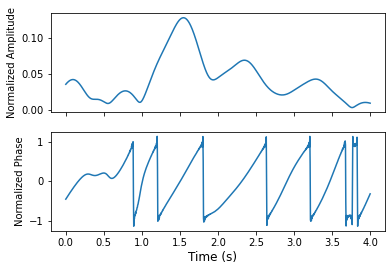

y=0.0, pred=0.6871935725212097


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]


        Train:
            loss=0.751
            acc=0.50
                    interictal, preictal
          precision= 0.61,    0.50
          recall=    0.01,    0.99 
          f1=        0.02,    0.67

        Test:
            loss=0.764
            acc=0.50
                    interictal, preictal
          precision= 0.54,    0.50
          recall=    0.01,    1.00 
          f1=        0.01,    0.67

        Segment:
            loss=0.747
            acc=0.50
                    interictal, preictal
          precision= 0.00,    0.50
          recall=    0.00,    1.00
          f1=        0.00,    0.67


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
torch.random.manual_seed(1)
model = PredIctal().float()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_fn = nn.BCELoss()
model.apply(weights_init)
idx, ch_idx, freq_idx = 0,0,0
plot_init(train_dataloader, model, idx, ch_idx, freq_idx)
init_train_stats, _ = eval_loop(train_dataloader, model, loss_fn)
init_test_stats, _ = eval_loop(test_dataloader, model, loss_fn)
init_seg_stats, _ = eval_loop(test_dataloader, model, loss_fn, seg=True)
def print_stats(train_stats, test_stats):
    print("""
        Train:
            loss={:.3f}
            acc={:.2f}
                    interictal, preictal
          precision= {:.2f},    {:.2f}
          recall=    {:.2f},    {:.2f} 
          f1=        {:.2f},    {:.2f}

        Test:
            loss={:.3f}
            acc={:.2f}
                    interictal, preictal
          precision= {:.2f},    {:.2f}
          recall=    {:.2f},    {:.2f} 
          f1=        {:.2f},    {:.2f}""".format(
        train_stats[0], train_stats[1], train_stats[2][0], train_stats[2][1],
        train_stats[3][0], train_stats[3][1], train_stats[4][0], train_stats[4][1],
        test_stats[0], test_stats[1], test_stats[2][0], test_stats[2][1],
        test_stats[3][0], test_stats[3][1], test_stats[4][0], test_stats[4][1]))
def print_segstats(seg_stats):
    print("""
        Segment:
            loss={:.3f}
            acc={:.2f}
                    interictal, preictal
          precision= {:.2f},    {:.2f}
          recall=    {:.2f},    {:.2f}
          f1=        {:.2f},    {:.2f}""".format(
        seg_stats[0], seg_stats[1], seg_stats[2][0], seg_stats[2][1],
        seg_stats[3][0], seg_stats[3][1], seg_stats[4][0], seg_stats[4][1]))
print_stats(init_train_stats, init_test_stats)
print_segstats(init_seg_stats)

Train

In [121]:
train_stats, test_stats, seg_stats = [init_train_stats], [init_test_stats], [init_seg_stats]
for epoch in range(num_epochs):
    #Train
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    #Evaluate
    train_stat, _ = eval_loop(train_dataloader, model, loss_fn)
    test_stat, _ = eval_loop(test_dataloader, model, loss_fn)
    #seg_stat = seg_eval_loop(test_dataloader, model)

    if train_stat[0] > train_stats[-1][0]:
        scheduler.step()
        print("New Learnign Rate:", scheduler.get_last_lr()[0])
    
    print("Epoch:", epoch)
    print_stats(train_stat, test_stat)
    
    train_stats.append(train_stat)
    test_stats.append(test_stat)
    #seg_stats.append(seg_stat)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.708
            acc=0.61
                    interictal, preictal
          precision= 0.72,    0.57
          recall=    0.37,    0.86 
          f1=        0.48,    0.69

        Test:
            loss=1.122
            acc=0.57
                    interictal, preictal
          precision= 0.75,    0.54
          recall=    0.22,    0.93 
          f1=        0.34,    0.68


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1

        Train:
            loss=0.496
            acc=0.74
                    interictal, preictal
          precision= 0.69,    0.82
          recall=    0.87,    0.61 
          f1=        0.77,    0.70

        Test:
            loss=0.900
            acc=0.71
                    interictal, preictal
          precision= 0.69,    0.72
          recall=    0.74,    0.67 
          f1=        0.72,    0.70


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2

        Train:
            loss=0.364
            acc=0.80
                    interictal, preictal
          precision= 0.82,    0.78
          recall=    0.77,    0.83 
          f1=        0.79,    0.80

        Test:
            loss=0.713
            acc=0.76
                    interictal, preictal
          precision= 0.85,    0.70
          recall=    0.62,    0.89 
          f1=        0.72,    0.79


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 3

        Train:
            loss=0.738
            acc=0.73
                    interictal, preictal
          precision= 0.90,    0.66
          recall=    0.52,    0.94 
          f1=        0.66,    0.78

        Test:
            loss=2.089
            acc=0.64
                    interictal, preictal
          precision= 0.90,    0.58
          recall=    0.31,    0.97 
          f1=        0.46,    0.73


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4

        Train:
            loss=0.296
            acc=0.86
                    interictal, preictal
          precision= 0.91,    0.83
          recall=    0.81,    0.91 
          f1=        0.86,    0.87

        Test:
            loss=0.686
            acc=0.75
                    interictal, preictal
          precision= 0.88,    0.69
          recall=    0.59,    0.92 
          f1=        0.70,    0.79


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5

        Train:
            loss=0.245
            acc=0.89
                    interictal, preictal
          precision= 0.91,    0.87
          recall=    0.86,    0.92 
          f1=        0.89,    0.89

        Test:
            loss=0.691
            acc=0.77
                    interictal, preictal
          precision= 0.84,    0.72
          recall=    0.66,    0.87 
          f1=        0.74,    0.79


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 6

        Train:
            loss=0.265
            acc=0.87
                    interictal, preictal
          precision= 0.85,    0.90
          recall=    0.91,    0.84 
          f1=        0.88,    0.87

        Test:
            loss=0.516
            acc=0.80
                    interictal, preictal
          precision= 0.81,    0.78
          recall=    0.77,    0.82 
          f1=        0.79,    0.80


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7

        Train:
            loss=0.197
            acc=0.92
                    interictal, preictal
          precision= 0.95,    0.90
          recall=    0.89,    0.95 
          f1=        0.92,    0.92

        Test:
            loss=0.617
            acc=0.77
                    interictal, preictal
          precision= 0.86,    0.72
          recall=    0.66,    0.89 
          f1=        0.74,    0.80


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8

        Train:
            loss=0.192
            acc=0.92
                    interictal, preictal
          precision= 0.95,    0.90
          recall=    0.89,    0.95 
          f1=        0.92,    0.92

        Test:
            loss=0.733
            acc=0.77
                    interictal, preictal
          precision= 0.88,    0.70
          recall=    0.61,    0.92 
          f1=        0.72,    0.80


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.173
            acc=0.93
                    interictal, preictal
          precision= 0.95,    0.92
          recall=    0.91,    0.95 
          f1=        0.93,    0.93

        Test:
            loss=0.653
            acc=0.78
                    interictal, preictal
          precision= 0.83,    0.74
          recall=    0.70,    0.86 
          f1=        0.76,    0.79


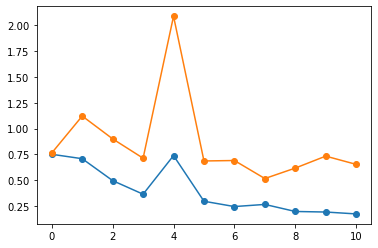

In [122]:
train_losses = np.array([train_stat[0] for train_stat in train_stats])
test_losses = np.array([test_stat[0] for test_stat in test_stats])

epoch_nums = np.arange(num_epochs+1)
plt.figure()
plt.hold = True
plt.plot(epoch_nums, train_losses, 'o-')
plt.plot(epoch_nums, test_losses, 'o-')

In [131]:
final_seg_stats, predsNlabels = eval_loop(test_dataloader, model, loss_fn, seg=True)
y, preds, true_preds = predsNlabels

  0%|          | 0/18 [00:00<?, ?it/s]

In [132]:
print_segstats(final_seg_stats)


        Segment:
            loss=0.279
            acc=1.00
                    interictal, preictal
          precision= 1.00,    1.00
          recall=    1.00,    1.00
          f1=        1.00,    1.00


Wow, perfect performance with thresh=0.5

ROC

ROCAUC= 1.0


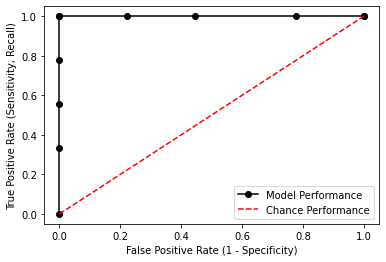

In [141]:
thresholds = np.linspace(0, 1, 11)
tprs, fprs, auc = roc_eval_loop(y, true_preds, thresholds)
print("ROCAUC=", auc)
plt.figure()
plt.hold = True
plt.plot(fprs, tprs, 'ko-')
plt.plot(fprs, fprs, 'r--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
_ = plt.legend(["Model Performance", "Chance Performance"])

## Patient 2!

In [333]:
preproc_patients(["Patient_2"])

Patient_2


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Datasets and Dataloaders

In [142]:
batch_size = 50 // 2

In [143]:
inter_segs = [seg_name for seg_name in os.listdir("DeepPreProcData/Patient_2") if "interictal" in seg_name]
pre_segs = [seg_name for seg_name in os.listdir("DeepPreProcData/Patient_2") if "preictal" in seg_name]
train_segs = inter_segs[:9]+pre_segs[:9]
test_segs = inter_segs[9:18]+pre_segs[9:]
n_subseg = 150
train_dataset = SeizureData("DeepPreProcData", "Patient_2", train_segs, n_subseg)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SeizureData("DeepPreProcData", "Patient_2", test_segs, n_subseg)
test_dataloader = DataLoader(test_dataset, batch_size=n_subseg, shuffle=False)

Note: $\lambda_{norm}$ is a L2 Norm Regularization parameter from [here](https://towardsdatascience.com/weight-decay-and-its-peculiar-effects-66e0aee3e7b8) 

In [153]:
learning_rate = 0.01 / 2
num_epochs = 20
epoch_nums = [epoch for epoch in range(num_epochs)]
lambda_norm = 0.05 * 100
weight_decay = lambda_norm*np.sqrt(batch_size/(num_epochs*len(train_dataset)))

In [154]:
print(weight_decay)

0.10758287072798381


Initialize

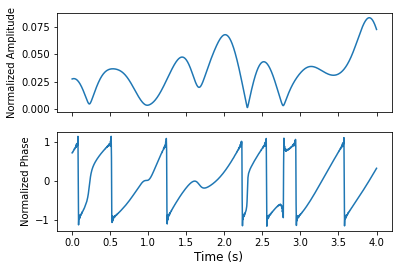

y=1.0, pred=0.3398483991622925


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]


        Train:
            loss=0.731
            acc=0.50
                    interictal, preictal
          precision= 0.50,    0.46
          recall=    0.95,    0.04 
          f1=        0.65,    0.08

        Test:
            loss=0.729
            acc=0.50
                    interictal, preictal
          precision= 0.50,    0.50
          recall=    0.96,    0.04 
          f1=        0.66,    0.08

        Segment:
            loss=0.715
            acc=0.50
                    interictal, preictal
          precision= 0.50,    0.00
          recall=    1.00,    0.00
          f1=        0.67,    0.00


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
torch.random.manual_seed(1)
model = PredIctal(num_channels=48).float()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_fn = nn.BCELoss()
model.apply(weights_init)
idx, ch_idx, freq_idx = 0,0,0
plot_init(train_dataloader, model, idx, ch_idx, freq_idx, num_channels=24)
init_train_stats, _ = eval_loop(train_dataloader, model, loss_fn)
init_test_stats, _ = eval_loop(test_dataloader, model, loss_fn)
init_seg_stats, _ = eval_loop(test_dataloader, model, loss_fn, seg=True)
print_stats(init_train_stats, init_test_stats)
print_segstats(init_seg_stats)

Train

In [156]:
train_stats, test_stats, seg_stats = [init_train_stats], [init_test_stats], [init_seg_stats]
for epoch in range(num_epochs):
    #Train
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    #Evaluate
    train_stat, _ = eval_loop(train_dataloader, model, loss_fn)
    test_stat, _ = eval_loop(test_dataloader, model, loss_fn)
    #seg_stat = seg_eval_loop(test_dataloader, model)

    if train_stat[0] > train_stats[-1][0]:
        scheduler.step()
        print("New Learnign Rate:", scheduler.get_last_lr()[0])
    
    print("Epoch:", epoch)
    print_stats(train_stat, test_stat)
    
    train_stats.append(train_stat)
    test_stats.append(test_stat)
    #seg_stats.append(seg_stat)

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.690
            acc=0.55
                    interictal, preictal
          precision= 0.54,    0.57
          recall=    0.67,    0.44 
          f1=        0.60,    0.50

        Test:
            loss=0.706
            acc=0.57
                    interictal, preictal
          precision= 0.56,    0.58
          recall=    0.65,    0.49 
          f1=        0.60,    0.53


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 1

        Train:
            loss=0.790
            acc=0.52
                    interictal, preictal
          precision= 0.56,    0.51
          recall=    0.16,    0.88 
          f1=        0.24,    0.64

        Test:
            loss=0.803
            acc=0.50
                    interictal, preictal
          precision= 0.52,    0.50
          recall=    0.14,    0.87 
          f1=        0.22,    0.64


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2

        Train:
            loss=0.685
            acc=0.58
                    interictal, preictal
          precision= 0.55,    0.74
          recall=    0.91,    0.25 
          f1=        0.69,    0.37

        Test:
            loss=0.726
            acc=0.57
                    interictal, preictal
          precision= 0.55,    0.68
          recall=    0.87,    0.28 
          f1=        0.67,    0.39


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3

        Train:
            loss=0.661
            acc=0.60
                    interictal, preictal
          precision= 0.60,    0.61
          recall=    0.64,    0.57 
          f1=        0.62,    0.59

        Test:
            loss=0.688
            acc=0.58
                    interictal, preictal
          precision= 0.58,    0.58
          recall=    0.59,    0.57 
          f1=        0.59,    0.58


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 4

        Train:
            loss=0.670
            acc=0.61
                    interictal, preictal
          precision= 0.60,    0.64
          recall=    0.71,    0.52 
          f1=        0.65,    0.57

        Test:
            loss=0.683
            acc=0.56
                    interictal, preictal
          precision= 0.55,    0.58
          recall=    0.65,    0.48 
          f1=        0.60,    0.52


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5

        Train:
            loss=0.631
            acc=0.65
                    interictal, preictal
          precision= 0.66,    0.65
          recall=    0.63,    0.68 
          f1=        0.65,    0.66

        Test:
            loss=0.682
            acc=0.59
                    interictal, preictal
          precision= 0.59,    0.59
          recall=    0.58,    0.60 
          f1=        0.58,    0.59


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6

        Train:
            loss=0.595
            acc=0.71
                    interictal, preictal
          precision= 0.68,    0.76
          recall=    0.80,    0.62 
          f1=        0.74,    0.69

        Test:
            loss=0.681
            acc=0.61
                    interictal, preictal
          precision= 0.59,    0.64
          recall=    0.73,    0.48 
          f1=        0.65,    0.55


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.000625
Epoch: 7

        Train:
            loss=0.647
            acc=0.65
                    interictal, preictal
          precision= 0.61,    0.75
          recall=    0.85,    0.45 
          f1=        0.71,    0.57

        Test:
            loss=0.709
            acc=0.56
                    interictal, preictal
          precision= 0.55,    0.61
          recall=    0.76,    0.37 
          f1=        0.64,    0.46


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8

        Train:
            loss=0.546
            acc=0.74
                    interictal, preictal
          precision= 0.74,    0.74
          recall=    0.75,    0.73 
          f1=        0.74,    0.74

        Test:
            loss=0.648
            acc=0.63
                    interictal, preictal
          precision= 0.63,    0.63
          recall=    0.63,    0.63 
          f1=        0.63,    0.63


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.542
            acc=0.75
                    interictal, preictal
          precision= 0.81,    0.70
          recall=    0.64,    0.85 
          f1=        0.72,    0.77

        Test:
            loss=0.667
            acc=0.60
                    interictal, preictal
          precision= 0.63,    0.58
          recall=    0.49,    0.72 
          f1=        0.55,    0.64


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0003125
Epoch: 10

        Train:
            loss=0.570
            acc=0.69
                    interictal, preictal
          precision= 0.86,    0.63
          recall=    0.46,    0.92 
          f1=        0.60,    0.75

        Test:
            loss=0.702
            acc=0.57
                    interictal, preictal
          precision= 0.64,    0.55
          recall=    0.34,    0.80 
          f1=        0.44,    0.65


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 11

        Train:
            loss=0.504
            acc=0.77
                    interictal, preictal
          precision= 0.80,    0.74
          recall=    0.71,    0.82 
          f1=        0.75,    0.78

        Test:
            loss=0.668
            acc=0.61
                    interictal, preictal
          precision= 0.63,    0.60
          recall=    0.55,    0.67 
          f1=        0.59,    0.64


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 12

        Train:
            loss=0.497
            acc=0.78
                    interictal, preictal
          precision= 0.83,    0.74
          recall=    0.69,    0.86 
          f1=        0.76,    0.79

        Test:
            loss=0.676
            acc=0.62
                    interictal, preictal
          precision= 0.64,    0.60
          recall=    0.53,    0.70 
          f1=        0.58,    0.65


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00015625
Epoch: 13

        Train:
            loss=0.506
            acc=0.74
                    interictal, preictal
          precision= 0.69,    0.83
          recall=    0.88,    0.61 
          f1=        0.77,    0.70

        Test:
            loss=0.710
            acc=0.63
                    interictal, preictal
          precision= 0.60,    0.70
          recall=    0.80,    0.46 
          f1=        0.69,    0.55


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14

        Train:
            loss=0.479
            acc=0.79
                    interictal, preictal
          precision= 0.84,    0.75
          recall=    0.71,    0.86 
          f1=        0.77,    0.80

        Test:
            loss=0.679
            acc=0.62
                    interictal, preictal
          precision= 0.64,    0.61
          recall=    0.55,    0.69 
          f1=        0.59,    0.65


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15

        Train:
            loss=0.463
            acc=0.80
                    interictal, preictal
          precision= 0.80,    0.80
          recall=    0.80,    0.80 
          f1=        0.80,    0.80

        Test:
            loss=0.682
            acc=0.63
                    interictal, preictal
          precision= 0.62,    0.63
          recall=    0.65,    0.61 
          f1=        0.63,    0.62


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 7.8125e-05
Epoch: 16

        Train:
            loss=0.469
            acc=0.78
                    interictal, preictal
          precision= 0.74,    0.84
          recall=    0.87,    0.69 
          f1=        0.80,    0.76

        Test:
            loss=0.709
            acc=0.63
                    interictal, preictal
          precision= 0.60,    0.67
          recall=    0.75,    0.51 
          f1=        0.67,    0.58


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 17

        Train:
            loss=0.453
            acc=0.80
                    interictal, preictal
          precision= 0.82,    0.79
          recall=    0.78,    0.83 
          f1=        0.80,    0.81

        Test:
            loss=0.688
            acc=0.62
                    interictal, preictal
          precision= 0.63,    0.62
          recall=    0.60,    0.64 
          f1=        0.61,    0.63


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 18

        Train:
            loss=0.447
            acc=0.81
                    interictal, preictal
          precision= 0.81,    0.81
          recall=    0.81,    0.81 
          f1=        0.81,    0.81

        Test:
            loss=0.688
            acc=0.63
                    interictal, preictal
          precision= 0.62,    0.63
          recall=    0.64,    0.62 
          f1=        0.63,    0.62


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 19

        Train:
            loss=0.443
            acc=0.82
                    interictal, preictal
          precision= 0.82,    0.82
          recall=    0.81,    0.82 
          f1=        0.82,    0.82

        Test:
            loss=0.688
            acc=0.63
                    interictal, preictal
          precision= 0.62,    0.63
          recall=    0.64,    0.62 
          f1=        0.63,    0.62


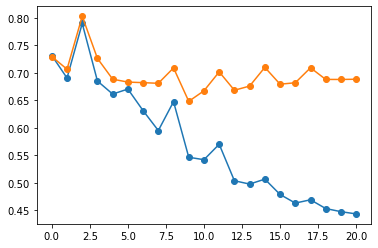

In [157]:
train_losses = np.array([train_stat[0] for train_stat in train_stats])
test_losses = np.array([test_stat[0] for test_stat in test_stats])

epoch_nums = np.arange(num_epochs+1)
plt.figure()
plt.hold = True
plt.plot(epoch_nums, train_losses, 'o-')
plt.plot(epoch_nums, test_losses, 'o-')

In [158]:
final_seg_stats, predsNlabels = eval_loop(test_dataloader, model, loss_fn, seg=True)
y, preds, true_preds = predsNlabels

  0%|          | 0/18 [00:00<?, ?it/s]

In [159]:
print_segstats(final_seg_stats)


        Segment:
            loss=0.569
            acc=0.78
                    interictal, preictal
          precision= 0.78,    0.78
          recall=    0.78,    0.78
          f1=        0.78,    0.78


ROC

ROCAUC= 0.8209876543209875


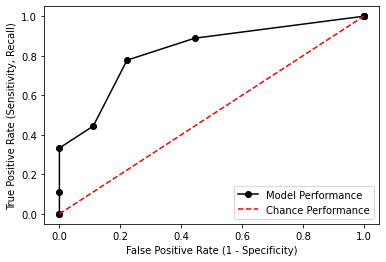

In [160]:
thresholds = np.linspace(0, 1, 11)
tprs, fprs, auc = roc_eval_loop(y, true_preds, thresholds)
print("ROCAUC=", auc)
plt.figure()
plt.hold = True
plt.plot(fprs, tprs, 'ko-')
plt.plot(fprs, fprs, 'r--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
_ = plt.legend(["Model Performance", "Chance Performance"])